In [2]:
#!/usr/bin/env python

import os, sys
import re
from pathlib import Path
import math

import scipy
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance
from scipy.stats import norm
from scipy.io import savemat
import pandas as pd
import numpy as np
#from statsmodels.stats.multitest import multipletests as mt
from matplotlib import pyplot as plt
import pylab
from sklearn.cluster import KMeans
import seaborn as sns

import dask.array as da
import dask_distance as dd

filepath = Path("F:/ucsf/bidc/IPI/data/qupath_output/20221031/")

for f in filepath.glob("*csv"):
    
    # set file paths based on user input
    root_dir = f.parent
    data_file = f.name
    sample_name = re.match("IPI[A-Z]*[0-9]*",f.stem)[0]
    print(sample_name)
    if 'tumor' in data_file:
        in_tumor_s='tumor'
    elif 'stroma' in data_file:
        in_tumor_s='stroma'

    exp_dir = Path(root_dir, sample_name)

    # Make a new folder for results if one does not yet exist
    try:
        os.mkdir(Path(root_dir, sample_name))
    except FileExistsError:
        pass

    # Filter data by tumor or stroma
    data = pd.read_csv(f)
    ncells=len(data)
    if ncells < 2:
        continue
    cell_types = list(set(data['Class'].values))
    ncell_types = len(cell_types)

    distance_threshold = 50

    # Pull centroids and calculate distance matrix
    centroid_coords = np.stack([data['Centroid X µm'],
                                data['Centroid Y µm']]).astype(np.float32).transpose()

    # initialize count dictionary
    near_count_dict = {}
    for ct in cell_types:
        near_count_dict['near_'+ct] = []

    # make indices first
    class_idx = {}
    for ct in cell_types:
        class_idx[ct] = np.where(data['Class']==ct)[0]

    for i in np.arange(centroid_coords.shape[0]):
        dists = np.sqrt(np.sum(np.square(centroid_coords-centroid_coords[i,:]), axis=1))<distance_threshold
        # don't count yourself as a neighbor
        dists[i] = False

        for ct in cell_types:
            near_count_dict['near_'+ct].append(np.sum(dists[class_idx[ct]]))

    result = pd.concat([data, pd.DataFrame(near_count_dict)], axis=1)

    result.to_csv(Path(exp_dir, sample_name + "_cell_data_neighborhood_counts.csv"))

IPIBLAD013
IPIBLAD020
IPIBLAD032



KeyboardInterrupt



,Name,Class,Parent,Centroid X µm,Centroid Y µm,DAPI: Cell: Mean,HLADR: Cell: Mean,CD8: Cell: Mean,CD163: Cell: Mean,CD4: Cell: Mean,...,near_cdc1,near_xcr1_cd163_double_pos,near_mac,near_cd4_t_cell,near_double_neg_t_cell,near_other,near_cd8_t_cell,near_double_pos_t_cell,near_cd163_pos_haldr_neg,near_other_myeloid_and_b_cells
0,other,other,Image,399.34,112.13,949.6183,333.7404,128.5267,139.7481,226.2443,...,0,0,0,0,0,145,0,0,25,0
1,other,other,Image,382.13,112.12,304.7661,198.6129,116.2393,128.2204,156.3333,...,0,0,0,0,0,152,0,0,29,0
2,other,other,Image,395.85,112.92,853.0000,308.2737,125.5579,134.3579,197.7368,...,0,0,0,0,0,150,0,0,28,0
3,other,other,Image,390.71,113.42,336.7168,260.6505,122.1239,126.7323,173.2589,...,0,0,0,0,0,151,0,0,31,0
4,other,other,Image,383.73,115.11,448.6019,283.4369,122.1942,130.1748,182.7961,...,0,0,0,0,0,157,0,0,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21140,cd163_pos_haldr_neg,cd163_pos_haldr_neg,Tumor,402.69,1995.40,614.4080,1217.3994,255.5833,9229.0605,3465.0144,...,0,0,11,2,5,300,6,0,158,0
21141,cd163_pos_haldr_neg,cd163_pos_haldr_neg,Tumor,406.41,1999.00,875.2974,971.8314,215.4590,6141.1968,1861.3865,...,0,0,11,2,5,300,6,0,155,0
21142,mac,mac,Tumor,408.91,2005.30,1079.0453,2282.8853,372.7738,17745.5820,2466.6833,...,0,0,10,2,5,302,6,0,154,0
21143,cd163_pos_haldr_neg,cd163_pos_haldr_neg,Tumor,403.29,2010.00,831.7601,1580.5648,257.3114,9096.5898,1571.6692,...,0,0,11,2,5,305,6,0,151,0


In [65]:
near_count_cols = near_count_dict.keys()

neighbor_count = pd.DataFrame(data=near_count_dict)
results = pd.concat([data, neighbor_count],axis=1)

means = results[near_count_cols].mean(axis=0)
std = results[near_count_cols].std(axis=0)

normed = (results[near_count_cols]-means)/std

In [66]:


def cluster_center_mean_dist(kmeans):

    centers = kmeans.cluster_centers_
    nclusters = len(np.unique(kmeans.labels_))

    dist = []

    for i in np.arange(nclusters-1):
        for j in np.arange(i+1, nclusters):
            dist.append(math.dist(centers[i,:], centers[j,:]))
    
    return np.mean(dist)


3
4
5
6
7
8
9
10


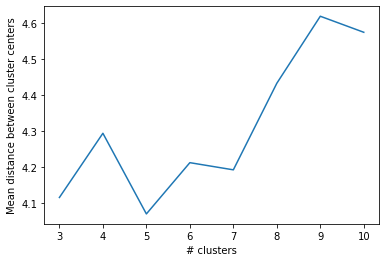

In [67]:
cluster_dist = []

for k in [3,4,5,6,7,8,9,10]: 
    print(k)
    kmeans = KMeans(n_clusters=k).fit(normed.values)
    cluster_dist.append([k, cluster_center_mean_dist(kmeans)])
cluster_dist = np.array(cluster_dist)
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(cluster_dist[:,0], cluster_dist[:,1])
plt.xlabel('# clusters')
plt.ylabel('Mean distance between cluster centers')
plt.savefig(Path(exp_dir, "cluster_diffs.png"), bbox_inches='tight', transparent=False)

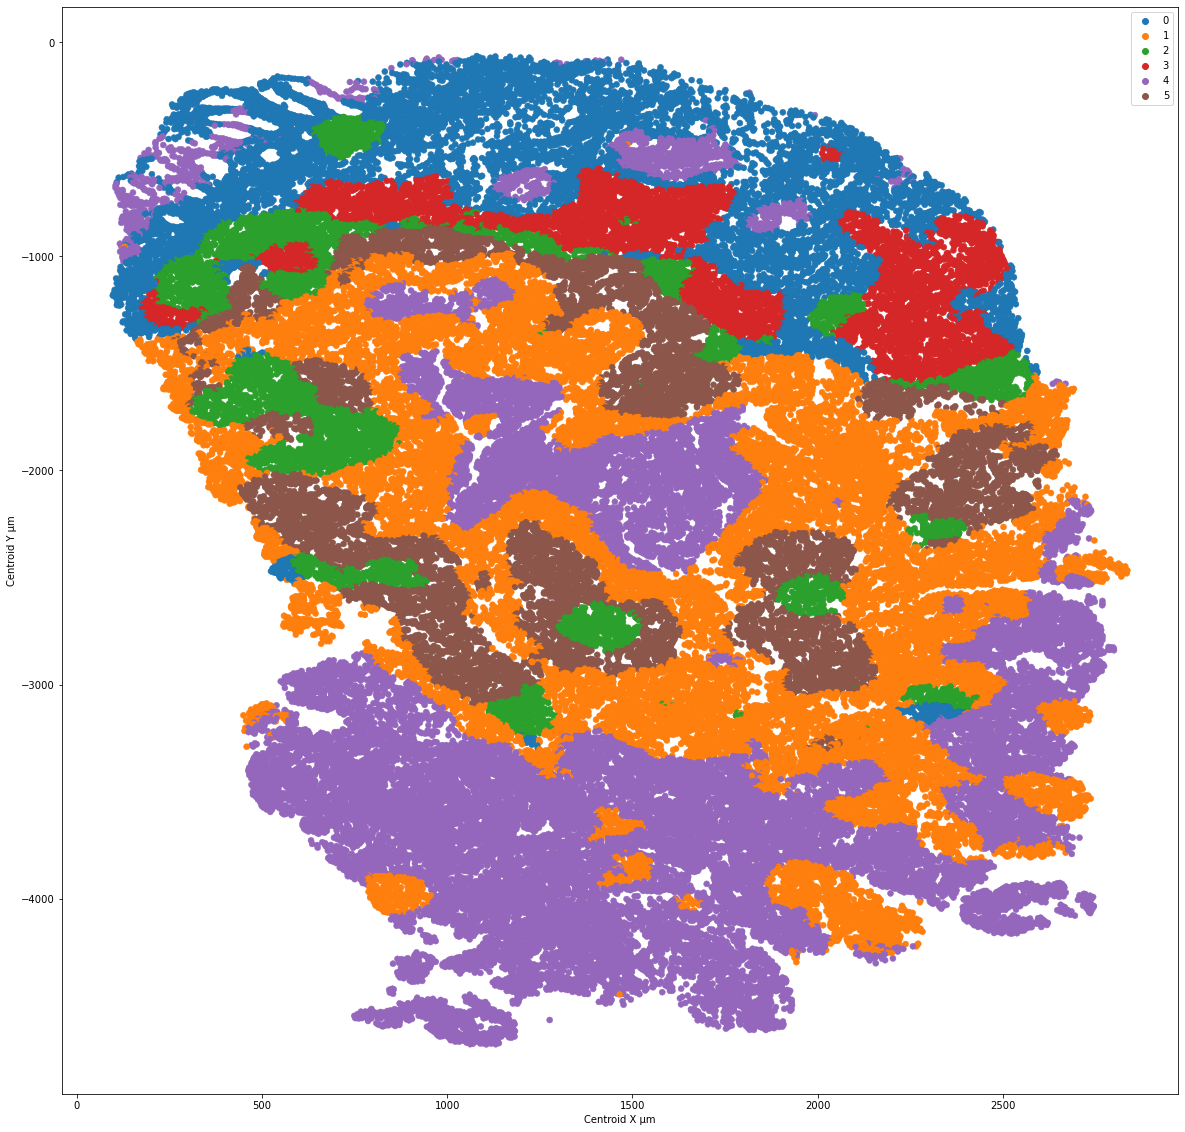

In [76]:


k = int(cluster_dist[np.argmax(cluster_dist[:,1]),0])
k=6
kmeans = KMeans(n_clusters=k).fit(normed.values)
centers = kmeans.cluster_centers_
fig = plt.figure(figsize=(20,20))
fig.patch.set_facecolor('white')

data['neighborhood'] = kmeans.labels_
#data['Centroid Y µm'] = -data['Centroid Y µm']
plot = sns.scatterplot(x='Centroid X µm', y='Centroid Y µm', hue='neighborhood',data=data, palette=sns.color_palette("tab10",len(set(kmeans.labels_))),edgecolor=None)
plot.legend()

plt.savefig(Path(exp_dir, "neighborhood_map_k6.png"),bbox_inches='tight',transparent=False)

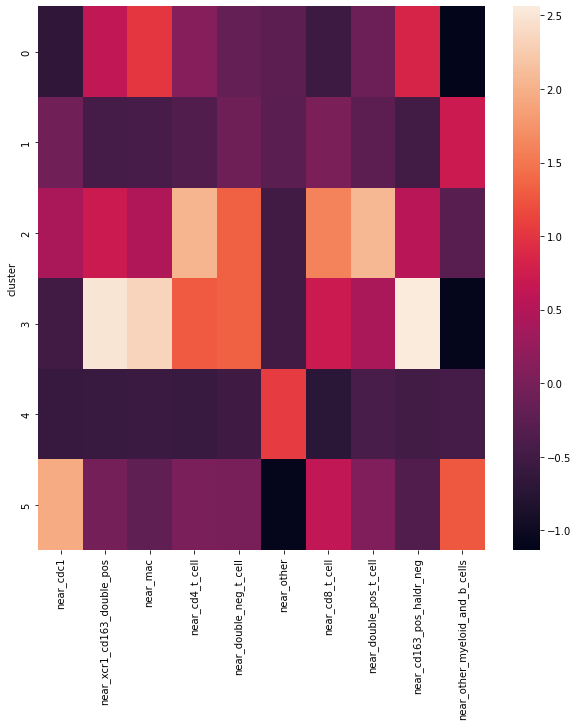

In [77]:

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('white')
plot = sns.heatmap(centers)
plot.set_xticklabels(near_count_cols, rotation=90)
plot.set(ylabel='cluster')

plt.savefig(Path(exp_dir, "heatmap_k6.png"),bbox_inches='tight',transparent=False)